In [8]:
import torchvision
import torch
import torch.utils.data as utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import tqdm
from torch.autograd import Variable
import argparse
import os
import gc
import matplotlib.pyplot as plt
from copy import deepcopy
from PIL import Image
data_path = '../datasets/'

from models import ConvBlock, Flatten, LeNet, MnistConvNet, RandomGame, RandomGamePos
# from backpack import backpack, extend
# from backpack.extensions import (
#     GGNMP,
#     HMP,
#     KFAC,
#     KFLR,
#     KFRA,
#     PCHMP,
#     BatchGrad,
#     BatchL2Grad,
#     DiagGGNExact,
#     DiagGGNMC,
#     DiagHessian,
#     SumGradSquared,
#     Variance,
# )

In [2]:
class MNISTCDataset(Dataset):
    
    """MNIST-C dataset."""

    def __init__(self, root, train, transform=None, target_transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if train:
            self.data = torch.tensor(np.load(root + '/train_images.npy'))
            self.targets = torch.tensor(np.load(root + '/train_labels.npy'))
        else:
            self.data = torch.tensor(np.load(root + '/test_images.npy'))
            self.targets = torch.tensor(np.load(root + '/test_labels.npy'))
            
        self.train=train
        self.root = root
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.targets)
    

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index][:,:,0], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


In [3]:
trans = ([transforms.ToTensor()])
trans = transforms.Compose(trans)

fulltrainset = torchvision.datasets.MNIST(root=data_path, train=True, download=True, transform=trans)
train_set, valset = torch.utils.data.random_split(fulltrainset, [55000, 5000])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
validloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False,
                                          num_workers=4, pin_memory=True)

test_set = torchvision.datasets.MNIST(root=data_path, train=False, download=True, transform=trans)
testloader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
nb_classes = 10

rand_labels_raw = torch.randint(0, 10, fulltrainset.targets.shape)
rand_labels_train, rand_labels_val = torch.utils.data.random_split(rand_labels_raw, [55000, 5000])

rand_labels_train = torch.utils.data.DataLoader(rand_labels_train, batch_size=128, shuffle=True, num_workers=4)
rand_labels_val = torch.utils.data.DataLoader(rand_labels_val, batch_size=128, shuffle=True, num_workers=4)

In [4]:
mnist_c_bright_trainset = MNISTCDataset(root='../datasets/mnist_c/fog', train=False, transform=trans)
mnist_c_bright_trainloader = torch.utils.data.DataLoader(mnist_c_bright_trainset, batch_size=128, shuffle=True, num_workers=4)

In [5]:
test_batch = next(iter(mnist_c_bright_trainloader))

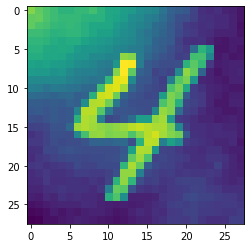

In [6]:
plt.imshow(test_batch[0][0][0].numpy())

In [7]:
def test(loader, model, save=False, epoch=0, bn_eval=True):
    
    if bn_eval: # forward prop data twice to update BN running averages
        model.train()
        for _ in range(2):
            for batch_idx, (inputs, targets) in enumerate(loader):
                if use_cuda:
                    inputs, targets = inputs.cuda(), targets.cuda()
                _ = (model(inputs))

    model.eval()
    correct, total, total_loss = 0,0,0
    tot_iters = len(loader)
#     for batch_idx in tqdm.tqdm(range(tot_iters), total=tot_iters):
#         inputs, targets = next(iter(loader)) 
    for batch_idx, (inputs, targets) in enumerate(loader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = (model(inputs, True))

            _, predicted = torch.max(nn.Softmax(dim=1)(outputs).data, 1)
            total += targets.size(0)
            correct += torch.sum(predicted.eq(targets.data)).cpu()
            total_loss += model.loss_fn(outputs, targets)

    # Save checkpoint.
    acc = 100.*float(correct)/float(total)
    loss = total_loss/tot_iters
#     if save and acc > best_acc:
#         best_acc = acc
#         print('Saving best model..')
#         state = {
#             'model': model0,
#             'epoch': epoch
#         }
#         with open(args.save_dir + '/best_model.pt', 'wb') as f:
#             torch.save(state, f)
    return loss, acc

In [32]:
class RandomGame(nn.Module):
    def __init__(self, model_func, num_class, multi_rand_layer=[], loss_type = 'softmax'):
        super(RandomGame, self).__init__()
        self.feature    = model_func()
        
        self.true_classifier = nn.Linear(self.feature.final_feat_dim, num_class, bias=True)

        self.multi_rand_layer = multi_rand_layer
        rand_trunk = []
        if len(multi_rand_layer) == 0:
            rand_trunk.append(nn.Linear(self.feature.final_feat_dim, num_class, bias=True))
        else:
            prev_layer_dim=self.feature.final_feat_dim
            for i in self.multi_rand_layer:
                rand_trunk.append(nn.Linear(prev_layer_dim, i, bias = True))
                rand_trunk.append(nn.ReLU(inplace=True))
                prev_layer_dim = i
            rand_trunk.append(nn.Linear(prev_layer_dim, num_class, bias = True))
            
        self.rand_classifier = nn.Sequential(*rand_trunk)
        
        self.num_class = num_class
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x, true_flag):
        embedding  = self.feature.forward(x)
        
        if true_flag:
            out = self.true_classifier.forward(embedding)
        else:
            out = self.rand_classifier.forward(embedding)
        return out, embedding
    
    def train_rand(self):
        for name, param in self.named_parameters():
            if 'rand' not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True
                
    def train_true(self):
        for name, param in self.named_parameters():
            if 'rand' not in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
                
    def train_true_classifier(self):
        for name, param in self.named_parameters():
            if 'true' not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True
                
    def train_encoder(self):
        for name, param in self.named_parameters():
            if 'classifier' in name:
                param.requires_grad = False
            else:
                param.requires_grad = True


In [33]:
model = RandomGame(model_func=MnistConvNet, num_class = 10)#, multi_rand_layer=[])

In [49]:
test_batch = next(iter(trainloader))

In [51]:
test_emb = model(test_batch[0], True)

In [53]:
test_emb.shape

torch.Size([128, 10])

In [76]:
cur_weights=[]
for name, param in model.named_parameters():
    if 'true' in name:
        cur_weights.append(param.data.clone())

In [50]:
for name, param in model.named_parameters():
    print(name)
    print(param.shape)
    if 'rand' in name:
        print(param.exp())
#     print(name)

feature.fc1.weight
torch.Size([300, 784])
feature.fc1.bias
torch.Size([300])
feature.fc2.weight
torch.Size([100, 300])
feature.fc2.bias
torch.Size([100])
true_classifier.weight
torch.Size([10, 100])
true_classifier.bias
torch.Size([10])
rand_classifier.log_weight
torch.Size([10, 100])
tensor([[0.9383, 1.2137, 1.0354, 0.8536, 0.8437, 0.9379, 1.0042, 0.9595, 1.0116,
         0.9611, 0.9303, 0.9120, 1.1674, 1.2485, 1.0649, 1.0517, 1.0865, 1.1391,
         0.9346, 0.7919, 0.9608, 1.0218, 1.0246, 0.9564, 1.0333, 1.0969, 1.2617,
         1.0815, 0.9507, 0.9167, 1.0379, 1.2106, 0.9011, 0.9173, 1.2503, 1.0218,
         1.1057, 0.8229, 0.8413, 0.8407, 1.1059, 0.8897, 0.9460, 1.1984, 0.9072,
         0.8324, 0.8737, 0.8006, 1.1244, 0.8725, 1.2410, 1.0298, 0.9960, 1.0302,
         0.9734, 0.9821, 1.2270, 0.9615, 1.1599, 0.8679, 1.0722, 0.8294, 0.8655,
         0.9241, 1.1052, 0.9204, 0.9277, 1.1525, 1.2116, 0.9156, 0.8224, 1.1718,
         0.8743, 1.0451, 0.9725, 1.0436, 1.0082, 1.2123, 0.8932, 1

In [52]:
ce_loss_fn = nn.CrossEntropyLoss()
mse_loss_fn = nn.MSELoss(reduction='mean')

In [53]:
true_parameters = list(model.feature.parameters()) + list(model.true_classifier.parameters())

# Optimizers
optimizer_T = torch.optim.SGD(true_parameters, lr = 0.1, weight_decay=0.0)
optimizer_R = torch.optim.SGD(model.rand_classifier.parameters(), lr=0.1, weight_decay=0.0)

In [54]:
optimizer_E = torch.optim.SGD(model.feature.parameters(), lr = 0.1, weight_decay=0)
optimizer_TC = torch.optim.SGD(model.true_classifier.parameters(), lr = 0.1, weight_decay=0)

In [37]:
inputs, labels = next(iter(trainloader))

In [48]:
def get_all_loss(model, outputs_true, outputs_rand, labels, rand_labels, alpha, gamma, mse_loss_func=None):
    
    true_loss=model.loss_fn(outputs_true, labels)
    if mse_loss_func is not None:
        rand_loss=mse_loss_func(outputs_rand, rand_labels)
    else:
        rand_loss=model.loss_fn(outputs_rand, rand_labels)
    loss = alpha*true_loss - gamma*rand_loss
    
    return true_loss, rand_loss, loss


def train_true_loop(model, optimizer_T, inputs, labels, rand_labels, alpha, gamma, mse_loss_func=None):
    # zero the parameter gradients
    optimizer_T.zero_grad()        
    model.train_true()
    outputs_true = model(inputs, True)
    outputs_rand = model(inputs, False)
    
    true_loss, rand_loss, loss = get_all_loss(model, outputs_true, outputs_rand, labels, rand_labels, 
                                              alpha, gamma, mse_loss_func)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
    loss.backward()
    optimizer_T.step()
#     return true_loss, rand_loss, loss
    
def init_rand_weights(model, init_type='prev'):
    if init_type == 'true':
        cur_weights=[]
        for name, param in model.named_parameters():
            if 'true' in name:
                cur_weights.append(param.data.clone())
                
        t=0
        for name, param in model.named_parameters():
            if 'rand' in name:
                param.data=cur_weights[t]
                t+=1
    elif init_type == 'reinit':
        if isinstance(model, RandomGamePos):
            for name, layer in model.named_children():
                if 'rand' in name:
                    layer.reset_parameters()
        else:
            for name, layer in model.named_children():
                if 'rand' in name:
                    layer[0].reset_parameters()
                    
                    
def train_rand_loop(model, optimizer, inputs, rand_labels, pos_weight=False,
                    reinit=False, init_type='prev', num_iter_rand_sb=1, mse_loss_func=None):
    
    if reinit:
        init_rand_weights(model, init_type=init_type)
        
    model.train_rand()
    for k in range(num_iter_rand_sb):
        optimizer.zero_grad()
        outputs_rand = model(inputs, False)
        if mse_loss_func is not None:
            rand_loss=mse_loss_func(outputs_rand, rand_labels)
        else:
            rand_loss=model.loss_fn(outputs_rand, rand_labels)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        rand_loss.backward()
        optimizer.step()
        if pos_weight:
            for p in model.rand_classifier.parameters():
                p.data.clamp_(0)
#     return rand_loss

def train_true_classifier_loop(model, optimizer, inputs, labels, 
                    init_type='prev', num_iter_rand_sb=1):
    
    if init_type == 'reinit':
        for name, layer in model.named_children():
            if 'true' in name:
                layer.reset_parameters()
        
    model.train_true_classifier()
    for k in range(num_iter_rand_sb):
        optimizer.zero_grad()
        outputs_true, _ = model(inputs, True)
        loss=model.loss_fn(outputs_true, labels)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        loss.backward()
        optimizer.step()
        
def train_encoder_loop(model, optimizer, inputs, labels, rand_labels, alpha, gamma, mse_loss_func=None):
    # zero the parameter gradients
    model.train_encoder()
    optimizer.zero_grad()        
    
    outputs_true = model(inputs, True)
    outputs_rand = model(inputs, False)
    
    true_loss, rand_loss, loss = get_all_loss(model, outputs_true, outputs_rand, labels, rand_labels, 
                                              alpha, gamma, mse_loss_func)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
    loss.backward()
    optimizer.step()
#     return true_loss, rand_loss, loss

In [109]:
all_embedding = []

In [143]:
checkpoint=torch.load('exp_logged/mnist_mnist_c/brightness/_convnet_trainfirst_iterT1_iterR1_iterRsb1_gam0.003_alf1.0_lrT0.01_lrR0.01_dgm0.95per300_ep15_simt_sep_rpb_seed0_inittypereinit_fromfresh/15.tar')

model.load_state_dict(checkpoint['state_dict'])

# init_rand_weights(model, 'true')

outputs_true, emb_true = model(inputs, True)
outputs_rand, emb_rand = model(inputs, False)

all_embedding.append(emb_rand.clone())

FileNotFoundError: [Errno 2] No such file or directory: 'exp_logged/mnist_mnist_c/brightness/_convnet_trainfirst_iterT1_iterR1_iterRsb1_gam0.003_alf1.0_lrT0.01_lrR0.01_dgm0.95per300_ep15_simt_sep_rpb_seed0_inittypereinit_fromfresh/15.tar'

In [149]:
all_embedding_stack = np.stack(all_embedding)

In [154]:
all_embedding_stack[:,0,3]

array([0.707626 , 1.2886751, 1.6251273, 1.5803208, 1.6432005, 1.7805538,
       1.7775501, 1.842689 , 1.7846127, 2.0102408, 1.9541191, 2.0461721,
       1.9932562, 2.0669484, 2.1290536, 2.2324197], dtype=float32)

In [82]:
train_true_classifier_loop(model, optimizer_TC, inputs, labels,
                           init_type='prev', num_iter_rand_sb=1)

In [83]:
outputs_true

tensor([[ 0.0813, -0.3591,  0.1400,  ...,  0.4027,  0.1349, -0.1287],
        [ 0.2843,  0.2435,  0.1626,  ...,  0.3280,  0.2451,  0.0100],
        [ 0.4577, -0.3580, -0.0257,  ...,  0.1060,  0.4364, -0.2737],
        ...,
        [ 0.1670, -0.2877,  0.2048,  ...,  0.4731, -0.0852, -0.0558],
        [ 0.3060, -0.3253, -0.0624,  ..., -0.0842,  0.3183, -0.2497],
        [ 0.0940,  0.3608,  0.3324,  ...,  0.1302,  0.3209, -0.4377]],
       grad_fn=<AddmmBackward>)

In [84]:
outputs_rand

tensor([[ 0.0395, -0.3267,  0.1457,  ...,  0.3531,  0.1920, -0.0370],
        [ 0.2668,  0.2190,  0.2317,  ...,  0.2688,  0.2767,  0.1356],
        [ 0.4349, -0.3591, -0.0394,  ...,  0.0683,  0.4957, -0.1550],
        ...,
        [ 0.1454, -0.2678,  0.2171,  ...,  0.4171, -0.0356,  0.0491],
        [ 0.2424, -0.3175, -0.1383,  ..., -0.0998,  0.3879, -0.1112],
        [ 0.0830,  0.3054,  0.3162,  ...,  0.0986,  0.3741, -0.3022]])

In [93]:
_, predicted = torch.max(nn.Softmax(dim=1)(outputs_true).data, 1)
total = labels.size(0)
correct = predicted.eq(labels.data).cpu().sum()

In [94]:
correct/total

tensor(0.1328)

In [ ]:
            _, predicted_rand = torch.max(nn.Softmax(dim=1)(outputs_rand).data, 1)
            correct_rand += predicted_rand.eq(rand_labels.data).cpu().sum()

In [53]:
train_true = True
iter_counter = 0
changer_iter = 5

In [54]:
validloss_all = []
validacc_all = []
testloss_all = []
testacc_all = []
trainloss_all = []
trainacc_all = []

In [55]:
correct=0
total=0
correct_rand=0
validacc=0
testacc=0
validloss=0
testloss=0
print_every=50

In [56]:
use_cuda=True

In [57]:
model.cuda()

RandomGame(
  (feature): LeNet(
    (fc1): Linear(in_features=784, out_features=300, bias=True)
    (fc2): Linear(in_features=300, out_features=100, bias=True)
  )
  (true_classifier): Linear(in_features=100, out_features=10, bias=True)
  (rand_classifier): PositiveLinear()
  (loss_fn): CrossEntropyLoss()
)

In [986]:
# torch.sum(model.true_classifier.weight)

# model.true_classifier.bias

# torch.sum(model.feature.fc1.weight)

In [58]:
gamma=0.25

In [59]:
model.train()

RandomGame(
  (feature): LeNet(
    (fc1): Linear(in_features=784, out_features=300, bias=True)
    (fc2): Linear(in_features=300, out_features=100, bias=True)
  )
  (true_classifier): Linear(in_features=100, out_features=10, bias=True)
  (rand_classifier): PositiveLinear()
  (loss_fn): CrossEntropyLoss()
)

## ce version

In [3]:
2%1

0

In [ ]:
outputs_rand

In [60]:
train_true=True
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_true = 0.0
    running_loss_rand = 0.0
    for i, (data, rand_labels) in enumerate(zip(trainloader, rand_labels_train), 0):
#     for i, data in enumerate(trainloader):

        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#         rand_labels_oh = torch.nn.functional.one_hot(rand_labels).float()
#         rand_labels = torch.randint(0, 10, labels.shape)
        if use_cuda:
            inputs, labels, rand_labels = inputs.cuda(), labels.cuda(), rand_labels.cuda()


        # forward + backward + optimize

        if train_true:
            # zero the parameter gradients
            optimizer_T.zero_grad()        
            model.train_true()
            outputs_true = model(inputs, True)
            outputs_rand = model(inputs, False)

            true_loss=ce_loss_fn(outputs_true, labels)
            rand_loss=ce_loss_fn(outputs_rand, rand_labels)
            loss = 1.5*true_loss - gamma*rand_loss

            loss.backward()
            optimizer_T.step()
        
        
        if not train_true:
            model.train_rand()
#             for k in range(20):
            optimizer_R.zero_grad()
            outputs_rand = model(inputs, False)
            loss = ce_loss_fn(outputs_rand, rand_labels)
#             print(loss.cpu().detach().numpy())
            loss.backward()
            optimizer_R.step()
#                 print(loss.cpu().detach().numpy())
#                 train_true=True

        outputs_true = model(inputs, True)
        outputs_rand = model(inputs, False)
        
        _, predicted = torch.max(nn.Softmax(dim=1)(outputs_true).data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        
        _, predicted_rand = torch.max(nn.Softmax(dim=1)(outputs_rand).data, 1)
        correct_rand += predicted_rand.eq(rand_labels.data).cpu().sum()
        
#         if i == 0:
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(loss.item())
#             trainacc_all.append(correct.numpy() / total * 100)
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, loss.item(), correct.numpy() / total * 100, validloss, validacc, testloss, testacc))

        # print statistics
        running_loss += loss.item()
        running_loss_true += true_loss.item()
        running_loss_rand += rand_loss.item()
        if i % print_every == print_every-1:   
#             print(i)
#             weight_all, grad_all, variance_all, gsnr_all = save_gsnr_batch(model)
#             weight_all_time.append(weight_all)
#             grad_all_time.append(grad_all)
#             variance_all_time.append(variance_all)
#             gsnr_all_time.append(gsnr_all)
            
#             validloss, validacc = test(validloader, model, bn_eval=False)
            testloss, testacc = test(mnist_c_bright_trainloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
            testloss_all.append(testloss)
            testacc_all.append(testacc)
            trainloss_all.append(running_loss / print_every)
            trainacc_all.append(correct.numpy() / total * 100)
            print('[%d, %5d] rand loss: %.3f, true loss: %.3f, loss: %.3f, train acc: %.3f, rand_train_acc: %.3f, test acc: %.3f, train_true is %s, gamma is %.2f' %
                  (epoch + 1, i + 1, running_loss_rand / print_every, running_loss_true / print_every, running_loss / print_every, 
                   correct.numpy() / total * 100, correct_rand.numpy() / total * 100, testacc, train_true, gamma))
            
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, running_loss / print_every, correct.numpy() / total * 100, validloss, validacc, testloss, testacc))
            running_loss = 0.0
            running_loss_true = 0.0
            running_loss_rand = 0.0
            correct = 0
            correct_rand=0
            total = 0

        iter_counter += 1
        if iter_counter >= 1 and train_true:
            train_true = False
            iter_counter = 0
        
        if iter_counter >= 1 and not train_true:
            train_true = True
            iter_counter = 0
            
#         iter_counter += 1
#         if iter_counter >= 2 and train_true:
#             train_true=False
#             iter_counter = 0
            
#         if iter_counter >= 150 and not train_true:
#             train_true=True
#             iter_counter = 0
#             print('train_true is ' + str(train_true))

#         if i % 50 == 49:
#             gamma *= 1.1
        
#     if epoch > 2:
#         print('setting gamma to 0 at epoch %d' % epoch)
#         gamma = 0
    
print('Finished Training')

[1,    50] rand loss: 2.314, true loss: 2.229, loss: 2.541, train acc: 39.312, rand_train_acc: 9.469, test acc: 11.120, train_true is False, gamma is 0.25
[1,   100] rand loss: 2.359, true loss: 1.689, loss: 2.159, train acc: 64.766, rand_train_acc: 9.641, test acc: 9.590, train_true is False, gamma is 0.25
[1,   150] rand loss: 2.368, true loss: 0.961, loss: 1.609, train acc: 75.969, rand_train_acc: 11.016, test acc: 10.010, train_true is False, gamma is 0.25
[1,   200] rand loss: 2.355, true loss: 0.674, loss: 1.393, train acc: 81.984, rand_train_acc: 11.688, test acc: 9.480, train_true is False, gamma is 0.25
[1,   250] rand loss: 2.362, true loss: 0.585, loss: 1.330, train acc: 84.656, rand_train_acc: 11.922, test acc: 9.920, train_true is False, gamma is 0.25
[1,   300] rand loss: 2.346, true loss: 0.506, loss: 1.269, train acc: 86.297, rand_train_acc: 11.453, test acc: 10.120, train_true is False, gamma is 0.25
[1,   350] rand loss: 2.348, true loss: 0.496, loss: 1.256, train acc

KeyboardInterrupt: 

In [953]:
gc.collect()

20

In [586]:
train_true=False
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_true = 0.0
    running_loss_rand = 0.0
    for i, (data, rand_labels) in enumerate(zip(trainloader, rand_labels_train), 0):
#     for i, data in enumerate(trainloader):

        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#         rand_labels_oh = torch.nn.functional.one_hot(rand_labels).float()
#         rand_labels = torch.randint(0, 10, labels.shape)
        if use_cuda:
            inputs, labels, rand_labels = inputs.cuda(), labels.cuda(), rand_labels.cuda()

        
        # zero the parameter gradients
        optimizer_T.zero_grad()        

        # forward + backward + optimize

        if not train_true:
            model.train_rand()
            for k in range(1):
                optimizer_R.zero_grad()
                outputs_rand = model(inputs, False)
                loss = ce_loss_fn(outputs_rand, rand_labels)
    #             print(loss.cpu().detach().numpy())
                loss.backward()
                optimizer_R.step()
#                 print(loss.cpu().detach().numpy())
                train_true=True
        
        model.train_true()
        outputs_true = model(inputs, True)
        outputs_rand = model(inputs, False)
        
        true_loss=ce_loss_fn(outputs_true, labels)
        rand_loss=ce_loss_fn(outputs_rand, rand_labels)
        loss = 1.5*true_loss - gamma*rand_loss
            
        loss.backward()
        optimizer_T.step()
        
        _, predicted = torch.max(nn.Softmax(dim=1)(outputs_true).data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        
        _, predicted_rand = torch.max(nn.Softmax(dim=1)(outputs_rand).data, 1)
        correct_rand += predicted_rand.eq(rand_labels.data).cpu().sum()
        
#         if i == 0:
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(loss.item())
#             trainacc_all.append(correct.numpy() / total * 100)
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, loss.item(), correct.numpy() / total * 100, validloss, validacc, testloss, testacc))

        # print statistics
        running_loss += loss.item()
        running_loss_true += true_loss.item()
        running_loss_rand += rand_loss.item()
        if i % print_every == print_every-1:   
#             print(i)
#             weight_all, grad_all, variance_all, gsnr_all = save_gsnr_batch(model)
#             weight_all_time.append(weight_all)
#             grad_all_time.append(grad_all)
#             variance_all_time.append(variance_all)
#             gsnr_all_time.append(gsnr_all)
            
#             validloss, validacc = test(validloader, model, bn_eval=False)
            testloss, testacc = test(mnist_c_bright_trainloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
            testloss_all.append(testloss)
            testacc_all.append(testacc)
            trainloss_all.append(running_loss / print_every)
            trainacc_all.append(correct.numpy() / total * 100)
            print('[%d, %5d] rand loss: %.3f, true loss: %.3f, loss: %.3f, train acc: %.3f, rand_train_acc: %.3f, test acc: %.3f, train_true is %s, gamma is %.2f' %
                  (epoch + 1, i + 1, running_loss_rand / print_every, running_loss_true / print_every, running_loss / print_every, 
                   correct.numpy() / total * 100, correct_rand.numpy() / total * 100, testacc, train_true, gamma))
            
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, running_loss / print_every, correct.numpy() / total * 100, validloss, validacc, testloss, testacc))
            running_loss = 0.0
            running_loss_true = 0.0
            running_loss_rand = 0.0
            correct = 0
            correct_rand=0
            total = 0

        iter_counter += 1
        if iter_counter >= 1 and train_true:
            train_true = False
            iter_counter = 0
            
#         iter_counter += 1
#         if iter_counter >= 2 and train_true:
#             train_true=False
#             iter_counter = 0
            
#         if iter_counter >= 150 and not train_true:
#             train_true=True
#             iter_counter = 0
#             print('train_true is ' + str(train_true))

        if i % 100 == 99:
            gamma *= 0.9
        
#     if epoch > 2:
#         print('setting gamma to 0 at epoch %d' % epoch)
#         gamma = 0
    
print('Finished Training')

[1,    50] rand loss: 2.298, true loss: 1.917, loss: 2.645, train acc: 51.828, rand_train_acc: 10.859, test acc: 19.920, train_true is True, gamma is 0.10
[1,   100] rand loss: 2.264, true loss: 0.746, loss: 0.893, train acc: 78.375, rand_train_acc: 15.391, test acc: 23.990, train_true is True, gamma is 0.10
[1,   150] rand loss: 2.247, true loss: 0.494, loss: 0.539, train acc: 85.188, rand_train_acc: 15.672, test acc: 42.090, train_true is True, gamma is 0.09
[1,   200] rand loss: 2.249, true loss: 0.413, loss: 0.417, train acc: 88.141, rand_train_acc: 15.984, test acc: 33.610, train_true is True, gamma is 0.09
[1,   250] rand loss: 2.246, true loss: 0.364, loss: 0.364, train acc: 89.531, rand_train_acc: 16.344, test acc: 42.690, train_true is True, gamma is 0.08
[1,   300] rand loss: 2.248, true loss: 0.338, loss: 0.325, train acc: 89.844, rand_train_acc: 15.859, test acc: 40.320, train_true is True, gamma is 0.08
[1,   350] rand loss: 2.248, true loss: 0.316, loss: 0.311, train acc:

KeyboardInterrupt: 

In [434]:
gc.collect()

38

## train without game

In [915]:
model.train_true()
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_true = 0.0
    running_loss_rand = 0.0
    for i, (data, rand_labels) in enumerate(zip(trainloader, rand_labels_train), 0):

        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#         rand_labels_oh = torch.nn.functional.one_hot(rand_labels).float()
            
        if use_cuda:
            inputs, labels, rand_labels = inputs.cuda(), labels.cuda(), rand_labels.cuda()

        
        # zero the parameter gradients
        optimizer_T.zero_grad()        

        # forward + backward + optimize

        outputs_true = model(inputs, True)
        
        loss=ce_loss_fn(outputs_true, labels)
            
        loss.backward()
        optimizer_T.step()
        
        _, predicted = torch.max(nn.Softmax(dim=1)(outputs_true).data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        
        
#         if i == 0:
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(loss.item())
#             trainacc_all.append(correct.numpy() / total * 100)
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, loss.item(), correct.numpy() / total * 100, validloss, validacc, testloss, testacc))

        # print statistics
        running_loss += loss.item()
        if i % print_every == print_every-1:   
#             print(i)
#             weight_all, grad_all, variance_all, gsnr_all = save_gsnr_batch(model)
#             weight_all_time.append(weight_all)
#             grad_all_time.append(grad_all)
#             variance_all_time.append(variance_all)
#             gsnr_all_time.append(gsnr_all)
            
#             validloss, validacc = test(validloader, model, bn_eval=False)
            testloss, testacc = test(mnist_c_bright_trainloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
            testloss_all.append(testloss)
            testacc_all.append(testacc)
            trainloss_all.append(running_loss / print_every)
            trainacc_all.append(correct.numpy() / total * 100)
            print('[%d, %5d] loss: %.3f, train acc: %.3f, test acc: %.3f, train_true is %s, gamma is %.2f' %
                  (epoch + 1, i + 1, running_loss / print_every, 
                   correct.numpy() / total * 100, testacc, train_true, gamma))
            
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, running_loss / print_every, correct.numpy() / total * 100, validloss, validacc, testloss, testacc))
            running_loss = 0.0
            running_loss_true = 0.0
            running_loss_rand = 0.0
            correct = 0
            correct_rand=0
            total = 0

#         iter_counter += 1
#         if iter_counter >= 1 and train_true:
#             train_true = False
#             iter_counter = 0
            
#         iter_counter += 1
#         if iter_counter >= 2 and train_true:
#             train_true=False
#             iter_counter = 0
            
#         if iter_counter >= 150 and not train_true:
#             train_true=True
#             iter_counter = 0
#             print('train_true is ' + str(train_true))

#         if i % 100 == 99:
#             gamma *= 1.1
    
print('Finished Training')

[1,    50] loss: 2.187, train acc: 43.438, test acc: 12.080, train_true is True, gamma is 0.10
[1,   100] loss: 1.297, train acc: 72.594, test acc: 10.610, train_true is True, gamma is 0.10
[1,   150] loss: 0.639, train acc: 82.391, test acc: 9.250, train_true is True, gamma is 0.10
[1,   200] loss: 0.474, train acc: 86.656, test acc: 10.200, train_true is True, gamma is 0.10
[1,   250] loss: 0.424, train acc: 87.922, test acc: 10.110, train_true is True, gamma is 0.10
[1,   300] loss: 0.391, train acc: 88.578, test acc: 11.690, train_true is True, gamma is 0.10
[1,   350] loss: 0.381, train acc: 89.078, test acc: 11.770, train_true is True, gamma is 0.10
[1,   400] loss: 0.354, train acc: 89.703, test acc: 12.020, train_true is True, gamma is 0.10
[2,    50] loss: 0.319, train acc: 91.147, test acc: 12.540, train_true is True, gamma is 0.10
[2,   100] loss: 0.312, train acc: 91.031, test acc: 12.600, train_true is True, gamma is 0.10
[2,   150] loss: 0.304, train acc: 91.422, test acc

In [569]:
gc.collect()

349

## mse version

In [570]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_true = 0.0
    running_loss_rand = 0.0
    for i, (data, rand_labels) in enumerate(zip(trainloader, rand_labels_train), 0):
#     for i, data in enumerate(trainloader):

        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        rand_labels_oh = torch.nn.functional.one_hot(rand_labels).float()
#         rand_labels = torch.randint(0, 10, labels.shape)
        if use_cuda:
            inputs, labels, rand_labels, rand_labels_oh = inputs.cuda(), labels.cuda(), rand_labels.cuda(), rand_labels_oh.cuda()

        
        # zero the parameter gradients
        optimizer_T.zero_grad()        

        # forward + backward + optimize

        if not train_true:
            model.train_rand()
            for k in range(1):
                optimizer_R.zero_grad()
                outputs_rand = model(inputs, False)
                loss = mse_loss_fn(outputs_rand, rand_labels_oh)
    #             print(loss.cpu().detach().numpy())
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
                optimizer_R.step()
#                 print(loss.cpu().detach().numpy())
                train_true=True
        
        model.train_true()
        outputs_true = model(inputs, True)
        outputs_rand = model(inputs, False)
        
        true_loss=ce_loss_fn(outputs_true, labels)
        rand_loss=mse_loss_fn(outputs_rand, rand_labels_oh)
        loss = 1.5*true_loss - gamma*rand_loss
            
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer_T.step()
        
        _, predicted = torch.max(nn.Softmax(dim=1)(outputs_true).data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        
        _, predicted_rand = torch.max(nn.Softmax(dim=1)(outputs_rand).data, 1)
        correct_rand += predicted_rand.eq(rand_labels.data).cpu().sum()
        
#         if i == 0:
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(loss.item())
#             trainacc_all.append(correct.numpy() / total * 100)
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, loss.item(), correct.numpy() / total * 100, validloss, validacc, testloss, testacc))

        # print statistics
        running_loss += loss.item()
        running_loss_true += true_loss.item()
        running_loss_rand += rand_loss.item()
        if i % print_every == print_every-1:   
#             print(i)
#             weight_all, grad_all, variance_all, gsnr_all = save_gsnr_batch(model)
#             weight_all_time.append(weight_all)
#             grad_all_time.append(grad_all)
#             variance_all_time.append(variance_all)
#             gsnr_all_time.append(gsnr_all)
            
#             validloss, validacc = test(validloader, model, bn_eval=False)
            testloss, testacc = test(mnist_c_bright_trainloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
            testloss_all.append(testloss)
            testacc_all.append(testacc)
            trainloss_all.append(running_loss / print_every)
            trainacc_all.append(correct.numpy() / total * 100)
            print('[%d, %5d] rand loss: %.3f, true loss: %.3f, loss: %.3f, train acc: %.3f, rand_train_acc: %.3f, test acc: %.3f, train_true is %s, gamma is %.2f' %
                  (epoch + 1, i + 1, running_loss_rand / print_every, running_loss_true / print_every, running_loss / print_every, 
                   correct.numpy() / total * 100, correct_rand.numpy() / total * 100, testacc, train_true, gamma))
            
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, running_loss / print_every, correct.numpy() / total * 100, validloss, validacc, testloss, testacc))
            running_loss = 0.0
            running_loss_true = 0.0
            running_loss_rand = 0.0
            correct = 0
            correct_rand=0
            total = 0

        iter_counter += 1
        if iter_counter >= 1 and train_true:
            train_true = False
            iter_counter = 0
            
#         iter_counter += 1
#         if iter_counter >= 2 and train_true:
#             train_true=False
#             iter_counter = 0
            
#         if iter_counter >= 150 and not train_true:
#             train_true=True
#             iter_counter = 0
#             print('train_true is ' + str(train_true))

        if i % 100 == 99:
            gamma *= 0.9
        
#     if epoch > 2:
#         print('setting gamma to 0 at epoch %d' % epoch)
#         gamma = 0
    
print('Finished Training')

[1,    50] rand loss: 0.105, true loss: 1.858, loss: 2.682, train acc: 52.141, rand_train_acc: 10.562, test acc: 29.930, train_true is True, gamma is 1.00
[1,   100] rand loss: 0.100, true loss: 0.752, loss: 1.029, train acc: 77.422, rand_train_acc: 12.078, test acc: 34.550, train_true is True, gamma is 1.00
[1,   150] rand loss: 94.333, true loss: 6.696, loss: -74.855, train acc: 53.484, rand_train_acc: 10.391, test acc: 17.630, train_true is True, gamma is 0.90
[1,   200] rand loss: 4932.527, true loss: 92.846, loss: -4300.005, train acc: 19.750, rand_train_acc: 11.344, test acc: 9.800, train_true is True, gamma is 0.90
[1,   250] rand loss: 44288.547, true loss: 363.182, loss: -35328.950, train acc: 11.594, rand_train_acc: 10.703, test acc: 9.820, train_true is True, gamma is 0.81
[1,   300] rand loss: 185581.833, true loss: 797.359, loss: -149125.247, train acc: 10.688, rand_train_acc: 10.094, test acc: 9.580, train_true is True, gamma is 0.81


KeyboardInterrupt: 

In [540]:
gc.collect()

426

In [541]:
outputs_rand

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_true = 0.0
    running_loss_rand = 0.0
    for i, data in enumerate(trainloader, 0):

        model.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        rand_labels = torch.randint(0, 10, labels.shape)
            
        if use_cuda:
            inputs, labels, rand_labels = inputs.cuda(), labels.cuda(), rand_labels.cuda()

        
        # zero the parameter gradients
        optimizer_T.zero_grad()
        

        # forward + backward + optimize
     
        if train_true:
            for name, param in model.named_parameters():
                if 'rand' not in name:
                    param.requires_grad = False
                else:
                    param.requires_grad = True
            for k in range(100):
                optimizer_R.zero_grad()
                outputs_rand = model(inputs, False)
                loss = model.loss_fn(outputs_rand, rand_labels)
    #             print(loss.cpu().detach().numpy())
                loss.backward()
                optimizer_R.step()
    #         print(loss.cpu().detach().numpy())
            train_true=False
        
        for name, param in model.named_parameters():
            if 'rand' not in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
                
        outputs_true = model(inputs, True)
        outputs_rand = model(inputs, False)
        
        true_loss=model.loss_fn(outputs_true, labels)
        rand_loss=model.loss_fn(outputs_rand, rand_labels)
        loss = 2.5*true_loss - gamma*(rand_loss)
            
        _, predicted = torch.max(nn.Softmax(dim=1)(outputs_true).data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        
        _, predicted_rand = torch.max(nn.Softmax(dim=1)(outputs_rand).data, 1)
        correct_rand += predicted_rand.eq(rand_labels.data).cpu().sum()
        
#         if i == 0:
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(loss.item())
#             trainacc_all.append(correct.numpy() / total * 100)
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, loss.item(), correct.numpy() / total * 100, validloss, validacc, testloss, testacc))

        
        loss.backward()
        optimizer_T.step()

        # print statistics
        running_loss += loss.item()
        running_loss_true += true_loss.item()
        running_loss_rand += rand_loss.item()
        if i % print_every == print_every-1:   
#             print(i)
#             weight_all, grad_all, variance_all, gsnr_all = save_gsnr_batch(model)
#             weight_all_time.append(weight_all)
#             grad_all_time.append(grad_all)
#             variance_all_time.append(variance_all)
#             gsnr_all_time.append(gsnr_all)
            
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(running_loss / print_every)
#             trainacc_all.append(correct.numpy() / total * 100)
            print('[%d, %5d] rand loss: %.3f, true loss: %.3f, loss: %.3f, train acc: %.3f, rand_train_acc: %.3f, train_true is %s, gamma is %.2f' %
                  (epoch + 1, i + 1, running_loss_rand / print_every, running_loss_true / print_every, running_loss / print_every, correct.numpy() / total * 100, correct_rand.numpy() / total * 100, train_true, gamma))
            
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, running_loss / print_every, correct.numpy() / total * 100, validloss, validacc, testloss, testacc))
            running_loss = 0.0
            running_loss_true = 0.0
            running_loss_rand = 0.0
            correct = 0
            correct_rand=0
            total = 0

        iter_counter += 1
        if iter_counter >= 5 and not train_true:
            train_true = True
            iter_counter = 0
            
#         iter_counter += 1
#         if iter_counter >= 2 and train_true:
#             train_true=False
#             iter_counter = 0
            
#         if iter_counter >= 150 and not train_true:
#             train_true=True
#             iter_counter = 0
#             print('train_true is ' + str(train_true))

        if i % 300 == 299:
            gamma *= 0.95
    
print('Finished Training')

In [281]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_true = 0.0
    running_loss_rand = 0.0
    for i, data in enumerate(trainloader, 0):

        model.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        rand_labels = torch.randint(0, 10, labels.shape)
            
        if use_cuda:
            inputs, labels, rand_labels = inputs.cuda(), labels.cuda(), rand_labels.cuda()

        
        # zero the parameter gradients
        optimizer_T.zero_grad()
        

        # forward + backward + optimize
     
        if train_true:
            for name, param in model.named_parameters():
                if 'rand' not in name:
                    param.requires_grad = False
                else:
                    param.requires_grad = True
            for k in range(100):
                optimizer_R.zero_grad()
                outputs_rand = model(inputs, False)
                loss = model.loss_fn(outputs_rand, rand_labels)
    #             print(loss.cpu().detach().numpy())
                loss.backward()
                optimizer_R.step()
    #         print(loss.cpu().detach().numpy())
            train_true=False
        
        for name, param in model.named_parameters():
            if 'rand' not in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
                
        outputs_true = model(inputs, True)
        outputs_rand = model(inputs, False)
        
        true_loss=model.loss_fn(outputs_true, labels)
        rand_loss=model.loss_fn(outputs_rand, rand_labels)
        loss = 2.5*true_loss - gamma*(rand_loss)
            
        _, predicted = torch.max(nn.Softmax(dim=1)(outputs_true).data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        
        _, predicted_rand = torch.max(nn.Softmax(dim=1)(outputs_rand).data, 1)
        correct_rand += predicted_rand.eq(rand_labels.data).cpu().sum()
        
#         if i == 0:
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(loss.item())
#             trainacc_all.append(correct.numpy() / total * 100)
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, loss.item(), correct.numpy() / total * 100, validloss, validacc, testloss, testacc))

        
        loss.backward()
        optimizer_T.step()

        # print statistics
        running_loss += loss.item()
        running_loss_true += true_loss.item()
        running_loss_rand += rand_loss.item()
        if i % print_every == print_every-1:   
#             print(i)
#             weight_all, grad_all, variance_all, gsnr_all = save_gsnr_batch(model)
#             weight_all_time.append(weight_all)
#             grad_all_time.append(grad_all)
#             variance_all_time.append(variance_all)
#             gsnr_all_time.append(gsnr_all)
            
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(running_loss / print_every)
#             trainacc_all.append(correct.numpy() / total * 100)
            print('[%d, %5d] rand loss: %.3f, true loss: %.3f, loss: %.3f, train acc: %.3f, rand_train_acc: %.3f, train_true is %s, gamma is %.2f' %
                  (epoch + 1, i + 1, running_loss_rand / print_every, running_loss_true / print_every, running_loss / print_every, correct.numpy() / total * 100, correct_rand.numpy() / total * 100, train_true, gamma))
            
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, running_loss / print_every, correct.numpy() / total * 100, validloss, validacc, testloss, testacc))
            running_loss = 0.0
            running_loss_true = 0.0
            running_loss_rand = 0.0
            correct = 0
            correct_rand=0
            total = 0

        iter_counter += 1
        if iter_counter >= 5 and not train_true:
            train_true = True
            iter_counter = 0
            
#         iter_counter += 1
#         if iter_counter >= 2 and train_true:
#             train_true=False
#             iter_counter = 0
            
#         if iter_counter >= 150 and not train_true:
#             train_true=True
#             iter_counter = 0
#             print('train_true is ' + str(train_true))

        if i % 300 == 299:
            gamma *= 0.95
    
print('Finished Training')

[1,    50] rand loss: 2.376, true loss: 1.603, loss: 1.633, train acc: 54.719, rand_train_acc: 12.016, train_true is False, gamma is 1.00
[1,   100] rand loss: 2.593, true loss: 0.681, loss: -0.891, train acc: 77.750, rand_train_acc: 14.016, train_true is False, gamma is 1.00
[1,   150] rand loss: 2.909, true loss: 0.607, loss: -1.392, train acc: 82.625, rand_train_acc: 14.016, train_true is False, gamma is 1.00
[1,   200] rand loss: 3.747, true loss: 1.716, loss: 0.544, train acc: 76.094, rand_train_acc: 13.062, train_true is False, gamma is 1.00
[1,   250] rand loss: 3.135, true loss: 0.891, loss: -0.908, train acc: 82.094, rand_train_acc: 13.594, train_true is False, gamma is 1.00
[1,   300] rand loss: 2.755, true loss: 0.418, loss: -1.709, train acc: 87.891, rand_train_acc: 14.734, train_true is False, gamma is 1.00
[1,   350] rand loss: 4.828, true loss: 2.030, loss: 0.488, train acc: 78.219, rand_train_acc: 14.141, train_true is False, gamma is 0.95
[1,   400] rand loss: 2.674, t

KeyboardInterrupt: 

In [271]:
gc.collect()

244

In [272]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_true = 0.0
    running_loss_rand = 0.0
    for i, data in enumerate(trainloader, 0):

        model.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        rand_labels = torch.randint(0, 10, labels.shape)
            
        if use_cuda:
            inputs, labels, rand_labels = inputs.cuda(), labels.cuda(), rand_labels.cuda()

        
        # zero the parameter gradients
        optimizer_T.zero_grad()
        

        # forward + backward + optimize
     
        if train_true:
            for name, param in model.named_parameters():
                if 'rand' not in name:
                    param.requires_grad = False
                else:
                    param.requires_grad = True
            for k in range(100):
                optimizer_R.zero_grad()
                outputs_rand = model(inputs, False)
                loss = model.loss_fn(outputs_rand, rand_labels)
    #             print(loss.cpu().detach().numpy())
                loss.backward()
                optimizer_R.step()
    #         print(loss.cpu().detach().numpy())
            train_true=False
        
        for name, param in model.named_parameters():
            if 'rand' not in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
                
        outputs_true = model(inputs, True)
        outputs_rand = model(inputs, False)
        
        true_loss=model.loss_fn(outputs_true, labels)
        rand_loss=model.loss_fn(outputs_rand, rand_labels)
        loss = 1*true_loss# - gamma*(2.3-rand_loss)
            
        _, predicted = torch.max(nn.Softmax(dim=1)(outputs_true).data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        
        _, predicted_rand = torch.max(nn.Softmax(dim=1)(outputs_rand).data, 1)
        correct_rand += predicted_rand.eq(rand_labels.data).cpu().sum()
        
#         if i == 0:
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(loss.item())
#             trainacc_all.append(correct.numpy() / total * 100)
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, loss.item(), correct.numpy() / total * 100, validloss, validacc, testloss, testacc))

        
        loss.backward()
        optimizer_T.step()

        # print statistics
        running_loss += loss.item()
        running_loss_true += true_loss.item()
        running_loss_rand += rand_loss.item()
        if i % print_every == print_every-1:   
#             print(i)
#             weight_all, grad_all, variance_all, gsnr_all = save_gsnr_batch(model)
#             weight_all_time.append(weight_all)
#             grad_all_time.append(grad_all)
#             variance_all_time.append(variance_all)
#             gsnr_all_time.append(gsnr_all)
            
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(running_loss / print_every)
#             trainacc_all.append(correct.numpy() / total * 100)
            print('[%d, %5d] rand loss: %.3f, true loss: %.3f, loss: %.3f, train acc: %.3f, rand_train_acc: %.3f, train_true is %s, gamma is %.2f' %
                  (epoch + 1, i + 1, running_loss_rand / print_every, running_loss_true / print_every, running_loss / print_every, correct.numpy() / total * 100, correct_rand.numpy() / total * 100, train_true, gamma))
            
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, running_loss / print_every, correct.numpy() / total * 100, validloss, validacc, testloss, testacc))
            running_loss = 0.0
            running_loss_true = 0.0
            running_loss_rand = 0.0
            correct = 0
            correct_rand=0
            total = 0

        iter_counter += 1
        if iter_counter >= 5 and not train_true:
            train_true = True
            iter_counter = 0
            
#         iter_counter += 1
#         if iter_counter >= 2 and train_true:
#             train_true=False
#             iter_counter = 0
            
#         if iter_counter >= 150 and not train_true:
#             train_true=True
#             iter_counter = 0
#             print('train_true is ' + str(train_true))

        if i % 300 == 299:
            gamma *= 1.1
    
print('Finished Training')

[1,    50] rand loss: 2.316, true loss: 2.167, loss: 2.167, train acc: 44.484, rand_train_acc: 11.719, train_true is False, gamma is 1.00
[1,   100] rand loss: 2.420, true loss: 1.231, loss: 1.231, train acc: 69.891, rand_train_acc: 12.703, train_true is False, gamma is 1.00
[1,   150] rand loss: 2.442, true loss: 0.647, loss: 0.647, train acc: 80.812, rand_train_acc: 13.125, train_true is False, gamma is 1.00
[1,   200] rand loss: 2.504, true loss: 0.490, loss: 0.490, train acc: 85.234, rand_train_acc: 12.531, train_true is False, gamma is 1.00
[1,   250] rand loss: 2.473, true loss: 0.433, loss: 0.433, train acc: 87.203, rand_train_acc: 13.781, train_true is False, gamma is 1.00
[1,   300] rand loss: 2.527, true loss: 0.395, loss: 0.395, train acc: 88.547, rand_train_acc: 13.406, train_true is False, gamma is 1.00
[1,   350] rand loss: 2.512, true loss: 0.367, loss: 0.367, train acc: 89.750, rand_train_acc: 13.828, train_true is False, gamma is 1.10
[1,   400] rand loss: 2.509, true 

In [495]:
for epoch in range(14):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        model.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        rand_labels = torch.randint(0, 10, labels.shape)
            
        if use_cuda:
            inputs, labels, rand_labels = inputs.cuda(), labels.cuda(), rand_labels.cuda()

        
        # zero the parameter gradients
        optimizer_T.zero_grad()
        optimizer_R.zero_grad()

        # forward + backward + optimize
        outputs_true = model(inputs, True)
        outputs_rand = model(inputs, False)
        
        if train_true:
            loss = 2*model.loss_fn(outputs_true, labels) - gamma*model.loss_fn(outputs_rand, rand_labels)
        else:
            loss = model.loss_fn(outputs_rand, rand_labels)
            
        _, predicted = torch.max(nn.Softmax(dim=1)(outputs_true).data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        
        _, predicted_rand = torch.max(nn.Softmax(dim=1)(outputs_rand).data, 1)
        correct_rand += predicted_rand.eq(rand_labels.data).cpu().sum()
        
#         if i == 0:
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(loss.item())
#             trainacc_all.append(correct.numpy() / total * 100)
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, loss.item(), correct.numpy() / total * 100, validloss, validacc, testloss, testacc))

        
        loss.backward()
        
        if train_true:
            optimizer_T.step()
        else:
            optimizer_R.step()

        # print statistics
        running_loss += loss.item()
        if i % print_every == print_every-1:   
#             print(i)
#             weight_all, grad_all, variance_all, gsnr_all = save_gsnr_batch(model)
#             weight_all_time.append(weight_all)
#             grad_all_time.append(grad_all)
#             variance_all_time.append(variance_all)
#             gsnr_all_time.append(gsnr_all)
            
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(running_loss / print_every)
#             trainacc_all.append(correct.numpy() / total * 100)
            print('[%d, %5d] train loss: %.3f, train acc: %.3f, rand_train_acc: %.3f, train_true is %s, gamma is %.2f' %
                  (epoch + 1, i + 1, running_loss / print_every, correct.numpy() / total * 100, correct_rand.numpy() / total * 100, train_true, gamma))
            
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, running_loss / print_every, correct.numpy() / total * 100, validloss, validacc, testloss, testacc))
            running_loss = 0.0
            correct = 0
            correct_rand=0
            total = 0
        iter_counter += 1
        if iter_counter >= 2 and train_true:
            train_true=False
            iter_counter = 0
            
        if iter_counter >= 150 and not train_true:
            train_true=True
            iter_counter = 0
#             print('train_true is ' + str(train_true))

        if i % 500 == 499:
            gamma *= 0.95
    
print('Finished Training')

[1,    50] train loss: 2.348, train acc: 8.094, rand_train_acc: 10.484, train_true is False, gamma is 0.50
[1,   100] train loss: 2.304, train acc: 8.484, rand_train_acc: 9.938, train_true is False, gamma is 0.50
[1,   150] train loss: 2.303, train acc: 9.172, rand_train_acc: 9.484, train_true is False, gamma is 0.50
[1,   200] train loss: 2.349, train acc: 7.672, rand_train_acc: 10.188, train_true is False, gamma is 0.50
[1,   250] train loss: 2.303, train acc: 8.891, rand_train_acc: 9.953, train_true is False, gamma is 0.50
[1,   300] train loss: 2.303, train acc: 9.297, rand_train_acc: 9.391, train_true is False, gamma is 0.50
[1,   350] train loss: 2.349, train acc: 8.203, rand_train_acc: 10.094, train_true is False, gamma is 0.50
[1,   400] train loss: 2.303, train acc: 9.078, rand_train_acc: 10.312, train_true is False, gamma is 0.50
[2,    50] train loss: 2.349, train acc: 8.490, rand_train_acc: 9.833, train_true is False, gamma is 0.50
[2,   100] train loss: 2.303, train acc: 8

[10,   300] train loss: 2.303, train acc: 8.469, rand_train_acc: 10.828, train_true is False, gamma is 0.50
[10,   350] train loss: 2.303, train acc: 8.922, rand_train_acc: 10.516, train_true is False, gamma is 0.50
[10,   400] train loss: 2.349, train acc: 8.797, rand_train_acc: 9.891, train_true is False, gamma is 0.50
[11,    50] train loss: 2.302, train acc: 8.255, rand_train_acc: 10.373, train_true is False, gamma is 0.50
[11,   100] train loss: 2.303, train acc: 8.594, rand_train_acc: 10.234, train_true is False, gamma is 0.50
[11,   150] train loss: 2.349, train acc: 9.000, rand_train_acc: 10.156, train_true is False, gamma is 0.50
[11,   200] train loss: 2.303, train acc: 8.484, rand_train_acc: 9.984, train_true is False, gamma is 0.50
[11,   250] train loss: 2.303, train acc: 8.266, rand_train_acc: 9.609, train_true is False, gamma is 0.50
[11,   300] train loss: 2.349, train acc: 8.984, rand_train_acc: 10.094, train_true is False, gamma is 0.50
[11,   350] train loss: 2.303, 

In [57]:
optimizer_T.zero_grad()

In [104]:
optimizer_R.zero_grad()

In [215]:
inputs, labels = next(iter(trainloader))

In [216]:
inputs=inputs.cuda()
labels=labels.cuda()

In [542]:
# forward + backward + optimize
outputs = model(inputs, False)

In [571]:
model.feature.fc1.weight[-2]

tensor([-1.2884e-02, -1.3882e-02,  1.2817e-02, -9.4555e-04,  3.0092e-02,
         1.0486e-02, -3.0941e-02, -4.4655e-03, -3.3369e-02, -1.8193e-02,
        -9.4091e-03, -1.3727e-03, -2.6099e-02, -5.4899e-03,  2.5781e-02,
         1.6908e-02,  1.7572e-02,  3.4798e-03,  2.0891e-02,  2.8016e-02,
        -2.0708e-02,  2.2318e-03, -2.9543e-02,  2.4213e-02, -6.9216e-03,
        -1.2713e-02, -3.1164e-02, -3.1157e-02, -2.5164e-02,  1.8522e-02,
        -2.3435e-02,  7.9300e-03, -2.5209e-02, -2.6475e-02, -3.1741e-02,
        -1.6724e-02, -8.0129e-03,  1.8957e-02, -7.8422e-04, -1.4845e-02,
        -1.9399e-02,  3.2636e-02,  3.7357e-03, -5.1018e-03, -1.9835e-02,
         6.9270e-03, -1.9509e-02, -3.5025e-02,  2.1834e-02, -1.0204e-02,
        -2.1467e-02,  3.0699e-02, -1.5840e-02,  1.4424e-02,  2.7146e-02,
         1.8442e-02, -1.6263e-02, -1.9906e-03,  3.1360e-02,  2.9571e-02,
         9.1939e-03,  2.5311e-02, -3.4110e-03,  1.5451e-02, -9.0994e-03,
        -1.9657e-03,  3.5384e-02,  5.8600e-03,  2.1

In [574]:
model.feature(inputs)[0]

tensor([ 487.3576,  563.0782,    0.0000,  788.0320, 1285.5168,  260.9083,
           0.0000,    0.0000,  899.2999,  262.7325,  766.0019,  916.5306,
         551.2318,  562.9424,    0.0000,  522.7163,    0.0000,  656.5974,
         278.9159,    0.0000,  150.0539,  949.6662,    0.0000,   40.0514,
         235.3155,  322.2774,  338.2378,    0.0000,    0.0000,    0.0000,
           0.0000,  622.0282,  898.8696,  274.3130,  704.2454,  542.8204,
           0.0000,  286.3525,  535.9585,    0.0000,  472.4174,    0.0000,
           0.0000,    0.0000,  935.0920,  518.3685,  858.5781,  425.1231,
         436.8321,  267.9036,    0.0000,    0.0000,  151.2569,    0.0000,
         280.9054,  469.7323,  854.7551,  328.7216,  236.1176,  259.5135,
         531.8068,  663.5306,  566.5142,  292.0876,  760.9315,    0.0000,
         430.0152,    0.0000,  224.1848,  204.6381,  123.6201,  201.6194,
         706.4742,  550.0683,  927.8320,  613.0057,  740.3270,    0.0000,
         404.3229,  769.3582,  624.085

In [285]:
outputs.shape

torch.Size([88, 10])

In [286]:
outputs[1]

tensor([-23443.8906,  11664.0293, -30977.0000,  18269.4180, -30130.8613,
        -35893.1562,  34281.3125,  15815.0801,  24913.7266,  15030.6855],
       device='cuda:0', grad_fn=<SelectBackward>)

In [287]:
torch.softmax(outputs, 1)[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0',
       grad_fn=<SelectBackward>)

In [102]:
model.feature.fc2.weight[0][0:10]

tensor([ 0.0003, -0.0016,  0.0095, -0.0396, -0.0370,  0.0073, -0.0448,  0.0378,
         0.0476,  0.0221], grad_fn=<SliceBackward>)

In [103]:
model.feature.fc2.weight.grad[0][0:10]

tensor([100., 100., 100., 100., 100., 100., 100., 100., 100., 100.])

In [100]:
model.feature.fc2.weight.grad[0][0:10] = 100

In [67]:
rand_labels = torch.randint(0, 10, labels.shape)

In [69]:
rand_labels.shape

torch.Size([128])

In [119]:
comp_loss = 2*model.loss_fn(outputs, labels) - model.loss_fn(outputs, rand_labels)

In [120]:
comp_loss

tensor(2.3295, grad_fn=<SubBackward0>)

In [108]:
loss.backward()        

In [115]:
optimizer_R.step()

In [116]:
model.rand_classifier.weight[0][0:10]

tensor([-1.0843, -0.9679, -0.9038, -1.0378, -1.0565, -0.9441, -1.0367, -0.9117,
        -1.0202, -1.0202], grad_fn=<SliceBackward>)

In [114]:
model.rand_classifier.weight.grad[0][0:10] = 100

In [ ]:
loss = criterion(outputs, labels)

## analyze metrics

In [26]:
import h5py

In [33]:
input_file = h5py.File('exp/mnist_mnist_c/translate/_lenet_trainfirst_iterT9999_iterR0_iterRsb1_gam0.0_alf1.0_lrT0.1_lrR0.1_ep15_inittypeprev_fromfresh/perf_metrics.h5', 'r')

In [53]:
checkpoint=torch.load('exp/mnist_mnist_c/fog/_lenet_randfirst_iterT0_iterR9999_iterRsb5_gam1.0_alf0.0_lrT0.1_lrR0.1_dgm0.98per300_ep15_csist_posr_inittypereinit_fromfresh/final_model.tar')

In [54]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [34]:
input_file.attrs['keys']

array(['train_loss', 'train_acc', 'val_loss', 'val_acc', 'test_loss',
       'test_acc'], dtype=object)

In [35]:
orig_train_loss = np.array(input_file['train_loss'])
orig_val_loss = np.array(input_file['val_loss'])
orig_test_loss = np.array(input_file['test_loss'])

orig_train_acc = np.array(input_file['train_acc'])
orig_val_acc = np.array(input_file['val_acc'])
orig_test_acc = np.array(input_file['test_acc'])

In [36]:
input_file.close()

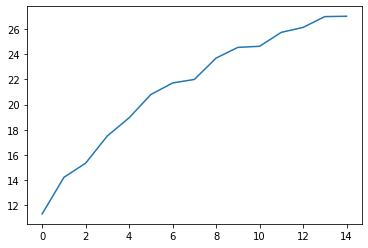

In [37]:
plt.plot(orig_test_acc)

In [60]:
orig_val_loss

array([2.2932558 , 0.5998181 , 0.55874026, 0.46569228, 0.45049158,
       0.4255676 , 0.3847248 , 0.40330774, 0.39204633, 0.37022448,
       0.3361154 , 0.3330903 , 0.32348287, 0.33008718, 0.30198124,
       0.31034064, 0.32422924, 0.28173184, 0.29986274, 0.31335452,
       0.2884902 , 0.3192304 , 0.26953194, 0.27360663, 0.28837383,
       0.28256062, 0.27020952, 0.27938017, 0.27500474, 0.28482935,
       0.2830521 , 0.25364268, 0.26431122, 0.26609266, 0.2623072 ,
       0.24247855, 0.31599626, 0.266008  , 0.25241718, 0.25159404,
       0.25465158, 0.2381976 , 0.26936   , 0.2949132 , 0.22524305,
       0.27760792, 0.27456635, 0.26015154, 0.2783044 , 0.28589192,
       0.25260788, 0.29126576, 0.2745214 , 0.31174105, 0.25607827,
       0.32937205, 0.25082582, 0.24957164, 0.27887645, 0.2519828 ,
       0.31203738, 0.3072598 , 0.28016475, 0.26036236, 0.25688252,
       0.2830533 , 0.2524959 , 0.2644796 , 0.28432667, 0.28638327,
       0.26213753, 0.26806572, 0.3232631 , 0.33061832, 0.29632

In [63]:
for param in model.rand_classifier.parameters():
    print(param)

Parameter containing:
tensor([[ 0.0221, -0.0360,  0.0109,  ..., -0.0212,  0.0420,  0.0539],
        [ 0.0665, -0.0150,  0.0654,  ..., -0.0893, -0.0182, -0.0902],
        [-0.0695, -0.0110, -0.0557,  ...,  0.0798, -0.0765,  0.0625],
        ...,
        [ 0.0803, -0.0046,  0.0478,  ...,  0.0588, -0.0892,  0.0326],
        [ 0.0360, -0.0322,  0.0301,  ..., -0.0137,  0.0948, -0.0082],
        [-0.0652,  0.0347, -0.0570,  ...,  0.0282,  0.0767,  0.0577]],
       requires_grad=True)
Parameter containing:
tensor([-0.0222,  0.0851,  0.0923, -0.0091,  0.0839, -0.0649, -0.0209,  0.0281,
        -0.0481,  0.0778,  0.0672, -0.0319, -0.0773, -0.0891, -0.0533,  0.0841,
        -0.0069, -0.0616,  0.0576,  0.0581,  0.0954,  0.0769,  0.0092,  0.0759,
        -0.0918,  0.0579,  0.0800,  0.0437,  0.0476, -0.0583, -0.0705, -0.0714,
         0.0169, -0.0576, -0.0534,  0.0145, -0.0887,  0.0359,  0.0824,  0.0519,
        -0.0280, -0.0057,  0.0309,  0.0348, -0.0592,  0.0321, -0.0852, -0.0133,
         0.0979